In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open("Ising_2D_h_dist_1675817875.pkl", "rb") as fp:   # Unpickling
    h_dist_list = pickle.load(fp)

(array([783., 331., 117.,  42.,  12.,   9.,   2.,   3.,   0.,   1.]),
 array([3.22963854e-03, 1.11784527e+00, 2.23246090e+00, 3.34707653e+00,
        4.46169216e+00, 5.57630779e+00, 6.69092341e+00, 7.80553904e+00,
        8.92015467e+00, 1.00347703e+01, 1.11493859e+01]),
 <BarContainer object of 10 artists>)

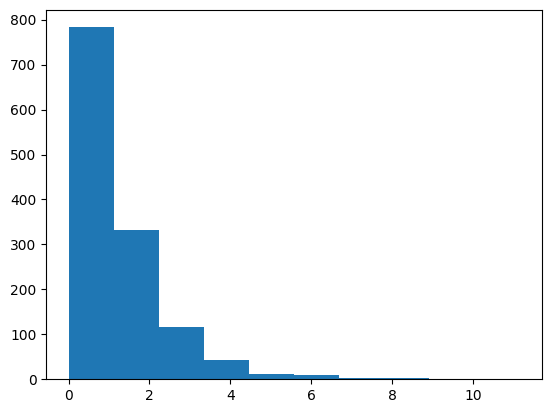

In [3]:
plt.hist(h_dist_list[-2])

In [4]:
with open("Ising_2D_input_1675817875.pkl", "rb") as fp:   # Unpickling
    input_dict = pickle.load(fp)

In [5]:
input_dict

{'L': 30,
 'steps': 855,
 'measure_list': array([900, 769, 658, 562, 481, 411, 351, 300, 257, 220, 188, 160, 137,
        117, 100,  86,  73,  62,  53,  46]),
 '(a,b)': (0.1, 0.1),
 'n_runs': 20}